# Tutorial 12: Visualization

## Overview
In this tutorial we are going to cover:

* [Image Visualization](#t12ImageVisualization)
    * [ImageDisplay](#t12ImageDisplay)
    * [BatchDisplay](#t12BatchDisplay)
    * [GridDisplay](#t12GridDisplay)
    * [DisplayTraces](#t12DisplayTraces)

### Preliminary Setup

Before we experience the magical visualization offered by FastEstimator, let's gather some dataset and get some imports out of the way. 

In [1]:
import warnings

import numpy as np
import torch

import fastestimator as fe

from fastestimator.dataset.data import montgomery

from fastestimator.op.numpyop import Batch
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import ChannelTranspose, ReadImage, Minmax, Binarize
from fastestimator.op.numpyop import Delete

from fastestimator.architecture.pytorch import UNet
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.trace.metric import Dice

from fastestimator.util import BatchDisplay, GridDisplay, ImageDisplay
from fastestimator.trace.io.batch_display import BatchDisplay as BatchDisplayTrace
from fastestimator.trace.io.grid_display import GridDisplay as GridDisplayTrace

from skimage import measure

warnings.filterwarnings('ignore')


In [2]:
class CombineLeftRightMask(fe.op.numpyop.NumpyOp):
    def forward(self, data, state):
        mask_left, mask_right = data
        dt1 = np.concatenate((mask_left,mask_right),axis=-1)
        return dt1
    
class BoundingBoxKeypoint(fe.op.numpyop.NumpyOp):
    def __init__(self, inputs, outputs, margin=0, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.margin = margin

    def forward(self, data, state):
        y_true = data
        if len(y_true.shape)==2:
            y_true = np.expand_dims(y_true, axis=-1)
        channels = y_true.shape[-1]
        
        box_cord = []
        keypoints_final = []
        
        for ch in range(channels):
            cord, keypoints = self.binary2boxcoords(y_true[:,:,ch],ch)
            if len(cord) > 0:
                cord = np.vstack(cord)
                keypoints = np.vstack(keypoints)
            else:
                cord = np.empty((0, 5))
                keypoints = np.empty((0, 2))
            box_cord.extend(cord)
            keypoints_final.extend(keypoints)
            
        return np.array(box_cord), np.array(keypoints_final)
        
    def binary2boxcoords(self, seg, channel):
        blobs, n_blob = measure.label(seg, background=0, return_num=True)
        obj_coords = []
        keypoints = []
        for b in range(1, n_blob + 1):
            blob_mask = blobs == b
            coords = np.argwhere(blob_mask)
            x1, y1 = coords.min(axis=0)
            x2, y2 = coords.max(axis=0)
            if self.margin > 0:
                y1 -= self.margin
                x1 -= self.margin
                y2 += self.margin
                x2 += self.margin
                y1 = max(0, y1)
                x1 = max(0, x1)
                y2 = min(y2, seg.shape[1] - 1)
                x2 = min(x2, seg.shape[0] - 1)
            obj_coords.append([y1, x1, y2-y1, x2-x1, channel])
            keypoints.append([y1, x1])
        return obj_coords, keypoints


In [3]:
csv = montgomery.load_data(root_dir='/raid/shared_data/')
eval_dt = csv.split(0.2)

pipeline = fe.Pipeline(
        train_data=csv,
        eval_data=eval_dt,
        ops=[ReadImage(inputs="image", parent_path=csv.parent_path, outputs="image", color_flag="gray"),
        ReadImage(inputs="mask_left", parent_path=csv.parent_path, outputs="mask_left", color_flag="gray"),
        ReadImage(inputs="mask_right",
                  parent_path=csv.parent_path,
                  outputs="mask_right",
                  color_flag="gray",
                  mode='!infer'),
        CombineLeftRightMask(inputs=("mask_left", "mask_right"), outputs="mask"),
        Delete(keys=["mask_left", "mask_right"]),
        Resize(image_in="image", width=128, height=128),
        Resize(image_in="mask", width=128, height=128),
        Minmax(inputs="image", outputs="image"),
        Binarize(inputs="mask", outputs="binary_mask", threshold=255/2),
        BoundingBoxKeypoint(inputs="binary_mask", outputs=["bbox_gt","keypoints"],margin=0),
        ChannelTranspose(inputs=["image","binary_mask"],outputs=["image","binary_mask"]),
        Batch(batch_size=4, pad_value=0)
        ])

Lets's see what are the outputs of our defined pipeline

In [4]:
a = pipeline.get_results()

for key, val in a.items():
    print(key, val.size())

image torch.Size([4, 1, 128, 128])
mask torch.Size([4, 128, 128, 2])
binary_mask torch.Size([4, 2, 128, 128])
bbox_gt torch.Size([4, 2, 5])
keypoints torch.Size([4, 2, 2])


<a id='t12ImageVisualization'></a>

## Image Visualization

So now that we have defined our pipeline and verified its output shape, we are ready to visualize them. In FastEstimator we offer utility tools like ImageDisplay, BatchDisplay and GridDisplay which can be used to  visualize images while combining different image components to improve your visualization experience.

<a id='t12ImageDisplay'></a>

### ImageDisplay

Lets use ImageDisplay to visualize Chest XRay. ImageDisplay works on the assumption that the input image will be a 3-dimensional image. If the image is a torch tensor we assume it to be channel first, whereas if the image is a tf tensor or a np array are assume them to be channel last. 
Either way, only 1 or 3 channel images are supported.

In [5]:
ImageDisplay(image=a["image"][0],title="Original Xray").show()

One can also use ImageDisplay to overlay mask on the original Image. 

Masks here must be 2-dimensional or 3-dimentional tensors. Tensors may be 3-dimensional with the last dimension indicating multiple different masks. They may be combined with label(s) if desired (mask, label) as shown below.

NOTE: In the below cells, the interactive mode has been turned off to reduce  the overall size of the notebook, but use can change this mode to True and experience the interactive visualization offered by FastEstimator

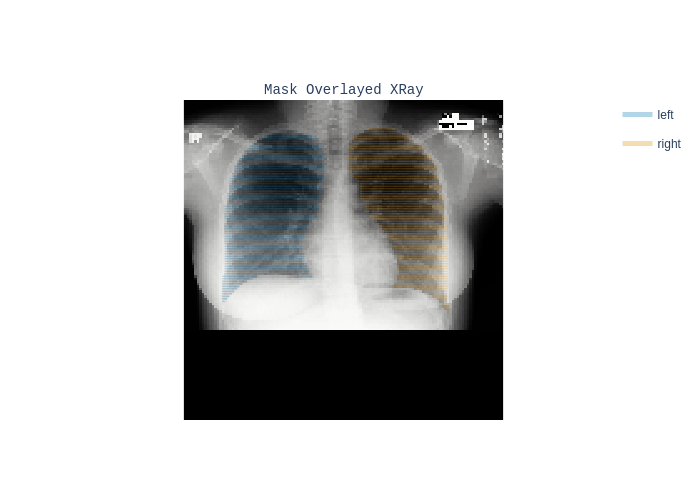

In [6]:
ImageDisplay(image=a["image"][0],
             masks=(a["mask"][0],['left','right']), 
             mask_threshold=0.5,
             title="Mask Overlayed XRay").show(interactive=False)

NOTE: In the cell above, notice that we set the parameter 'mask_threshold' to 0.5 . In case of multi-dimentional masks, the parameter 'mask_threshold' must be chosen to binarize the (non-binarized)mask and ensure different color maps for each mask dimention. In the case of multi-dimentional masks where the parameter 'mask_threshold' is set to NONE, ImageDisplay display the probability map of the mask by default as shown below. Also in such a case 'label' cannot be provided along with masks

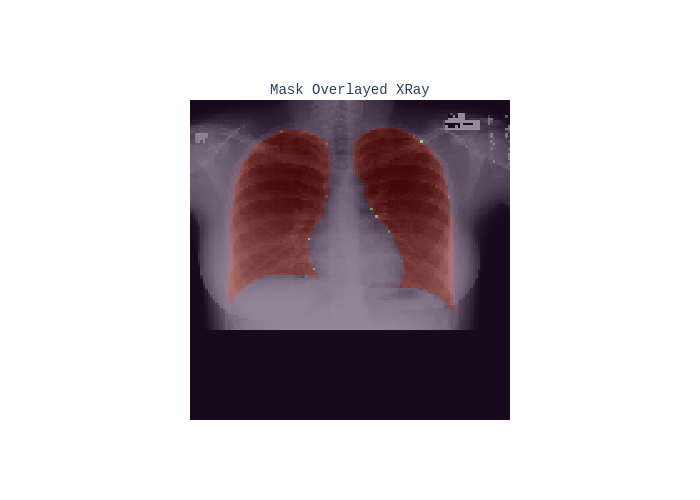

In [7]:
ImageDisplay(image=a["image"][0],
             masks=a["mask"][0],
             title="Mask Overlayed XRay").show(interactive=False)

One can also use ImageDisplay to overlay bounding box on the original Image. 

ImageDisplay accepts one or more bounding boxes of the form (x0, y0, width, height label), where (x0, y0) is the top left corner of the box. These may also be encoded in a tensor of shape (4,) or (N,4) for multiple boxes.

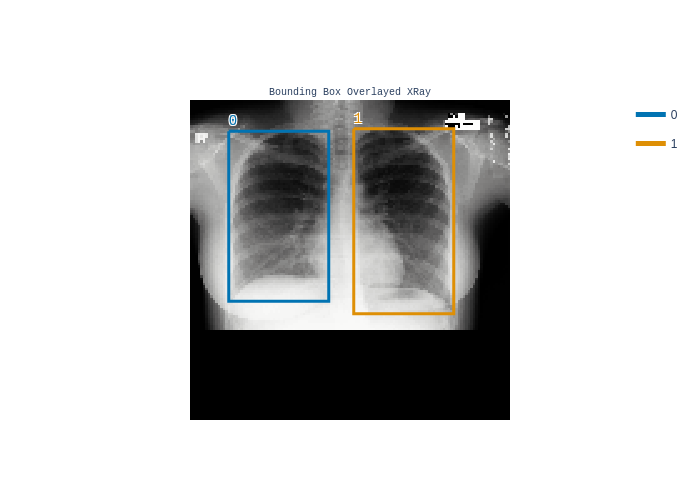

In [8]:
ImageDisplay(image=a["image"][0],
             bboxes= a["bbox_gt"][0],
             title="Bounding Box Overlayed XRay").show(interactive=False)

ImageDisplay can be used to overlay keypoints on  the original image.

Keypoints are expected to either be a 1D tensor of shape (2,) or to be a 2D tensor of shape (N,2) indicating multiple 1D keypoints. Similar to the masks, keypoints may be combined with label(s) if desired: (keypoint, label). 

NOTE : (x,y) coordinates of keypoints indicate distance from the top left of an image, with negative or None values indicating that a keypoint was not detected.

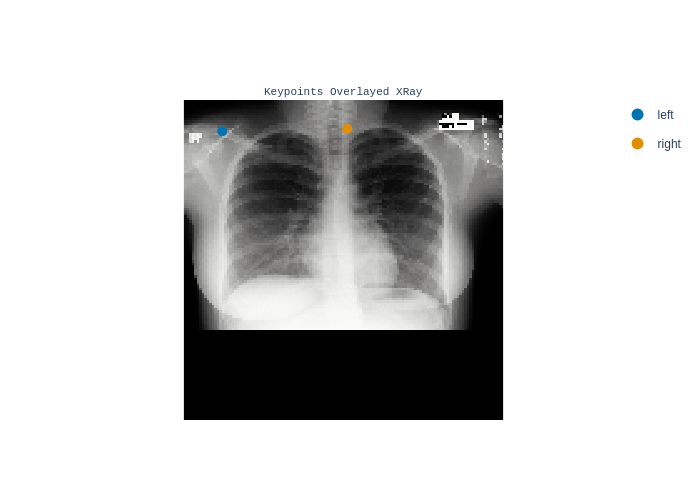

In [9]:
ImageDisplay(image=a["image"][0],
             keypoints= (a["keypoints"][0],['left','right']),
             title="Keypoints Overlayed XRay").show(interactive=False)

Let's see how they look together

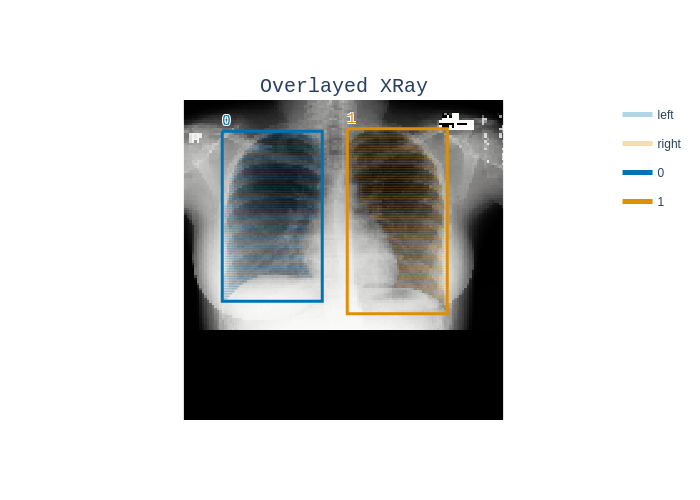

In [10]:
ImageDisplay(image=a["image"][0],
             masks=(a["mask"][0],['left','right']),
             bboxes= a["bbox_gt"][0], 
             mask_threshold=0.5,
             title="Overlayed XRay").show(interactive=False)

<a id='t12BatchDisplay'></a>

### BatchDisplay

BatchDisplay works the same way as ImageDisplay, the only difference being one can visualize multiple samples from a Batch at the same time. Lets visulaize Overlayed Image for the whole Batch.

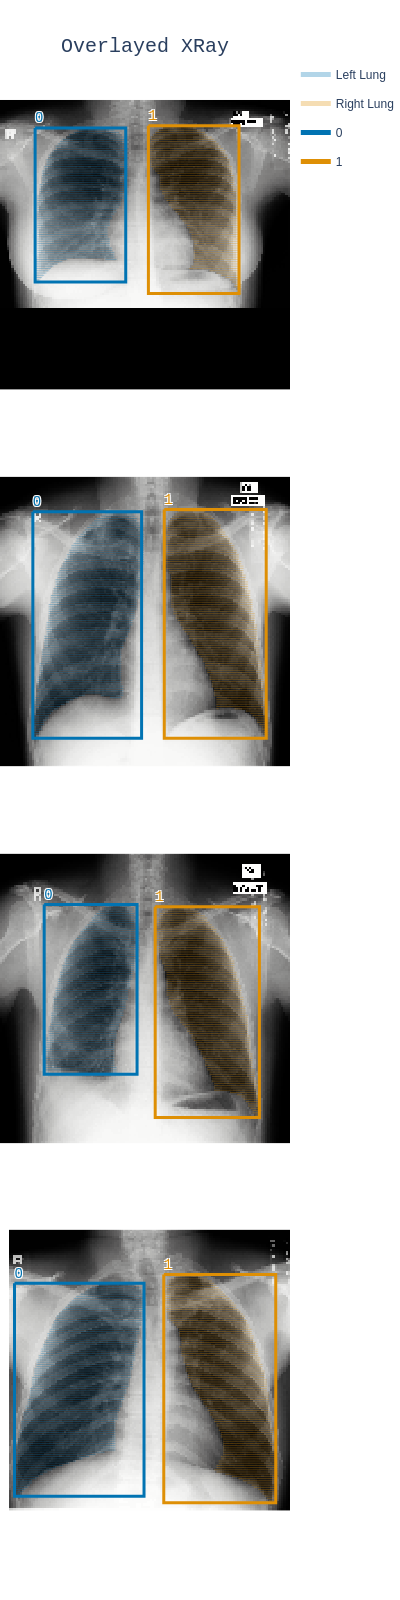

In [11]:
BatchDisplay(image=a["image"],
             masks=(a["mask"], ['Left Lung', 'Right Lung']),
             bboxes= a["bbox_gt"],
             mask_threshold=0.5,
             title="Overlayed XRay").show(interactive=False)

<a id='t12GridDisplay'></a>

### GridDisplay

We have seen how one can take advantage of ImageDisplay or BatchDisplay to improve their experience of visualization. GridDisplay can further enhance this eperience by displaying the output of ImageDisplay or BatchDisplay in form of a grid.

NOTE: ImageDisplay and BatchDisplay cannot be used together in the GridDisplay.

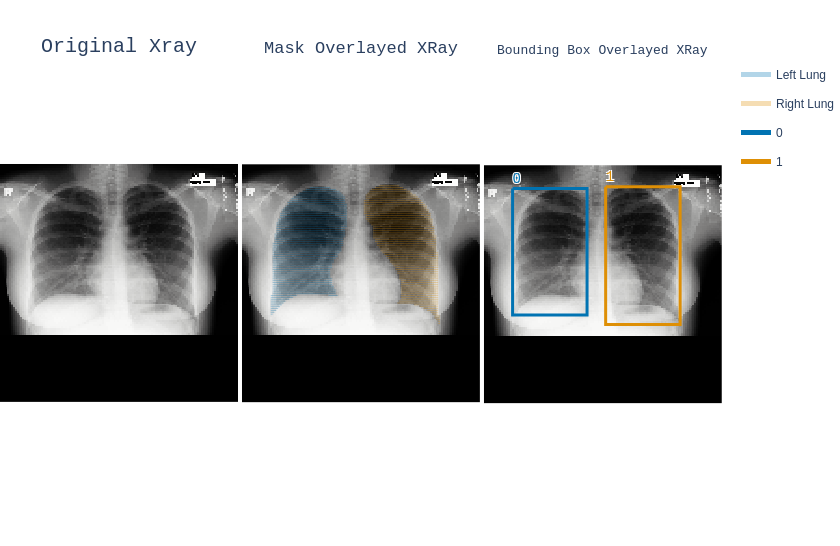

In [12]:
GridDisplay([ImageDisplay(image=a["image"][0],
                          title="Original Xray"), 
             ImageDisplay(image=a["image"][0],
                          masks=(a["mask"][0], ['Left Lung', 'Right Lung']),
                          mask_threshold=0.5,title="Mask Overlayed XRay"), 
             ImageDisplay(image=a["image"][0],
                          bboxes= a["bbox_gt"][0],
                          title="Bounding Box Overlayed XRay")
            ]).show(interactive=False)

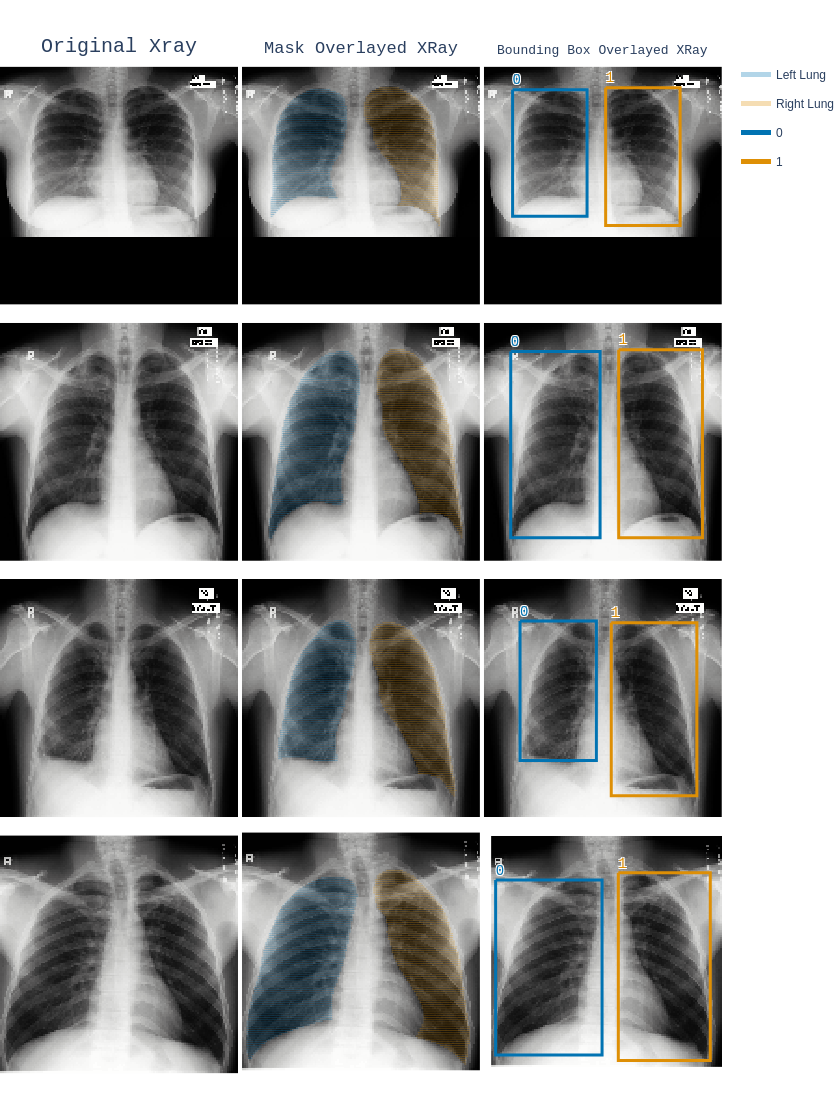

In [13]:
GridDisplay([BatchDisplay(image=a["image"],
                          title="Original Xray"), 
             BatchDisplay(image=a["image"],
                          masks=(a["mask"],['Left Lung', 'Right Lung']), 
                          mask_threshold=0.5,title="Mask Overlayed XRay"), 
             BatchDisplay(image=a["image"],
                          bboxes= a["bbox_gt"],
                          title="Bounding Box Overlayed XRay")
            ]).show(interactive=False)

<a id='t12DisplayTraces'></a>

## Display Traces

Along with the utility tools for visualization, FastEstimator also provides user with visualization traces. This provides users the opportunity to use functionalities of BatchDisplay and GridDisplay to visualize model output while training.


In [14]:
model = fe.build(
    model_fn=lambda: UNet(input_size=(1, 128, 128), output_channel=2),
    optimizer_fn=lambda x: torch.optim.Adam(params=x, lr=0.0001),
    model_name="lung_segmentation"
)

network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    CrossEntropy(inputs=("pred_segment", "binary_mask"), outputs="loss", form="binary"),
    UpdateOp(model=model, loss_name="loss")
])

In [15]:
traces = [
    Dice(true_key="binary_mask", pred_key="pred_segment"),
    GridDisplayTrace([BatchDisplayTrace(image="image",
                                        title="Original Xray"), 
                      BatchDisplayTrace(image="image",
                                        masks="mask",
                                        mask_threshold=0.5,
                                        title="GT Mask Overlay"), 
                      BatchDisplayTrace(image="image",
                                        masks="pred_segment",
                                        mask_threshold=0.5,
                                        title="Prediction Mask Overlay")])]

In [16]:
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=2,
                         log_steps=20,
                         traces=traces,
                         train_steps_per_epoch=None,
                         eval_steps_per_epoch=None)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; logging_interval: 20; num_device: 1;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints
FastEstimator-Train: step: 1; loss: 0.68167776;


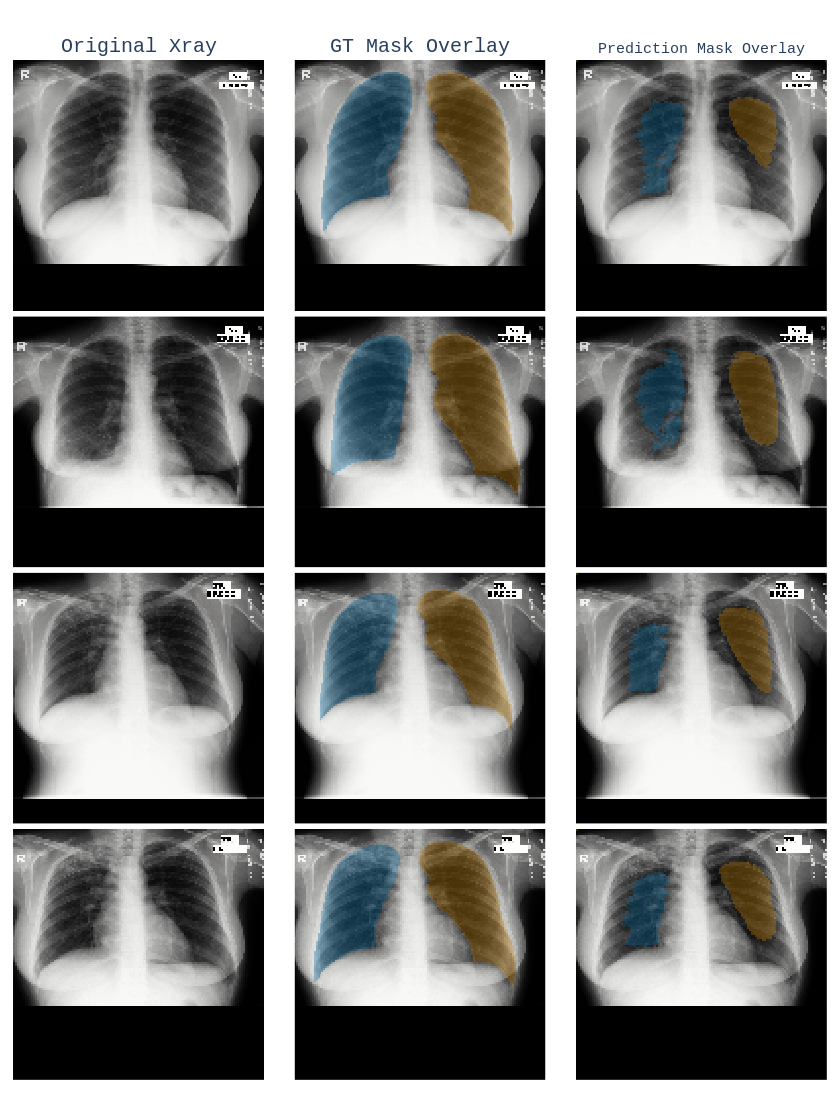

FastEstimator-Train: step: 20; loss: 0.17968386; steps/sec: 34.38;
FastEstimator-Train: step: 28; epoch: 1; epoch_time(sec): 13.61;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints
Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 1.19;
Eval Progress: 4/7; steps/sec: 1.65;
Eval Progress: 7/7; steps/sec: 3.55;
FastEstimator-Eval: step: 28; epoch: 1; Dice: 0.76438475; loss: 0.1285142;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints


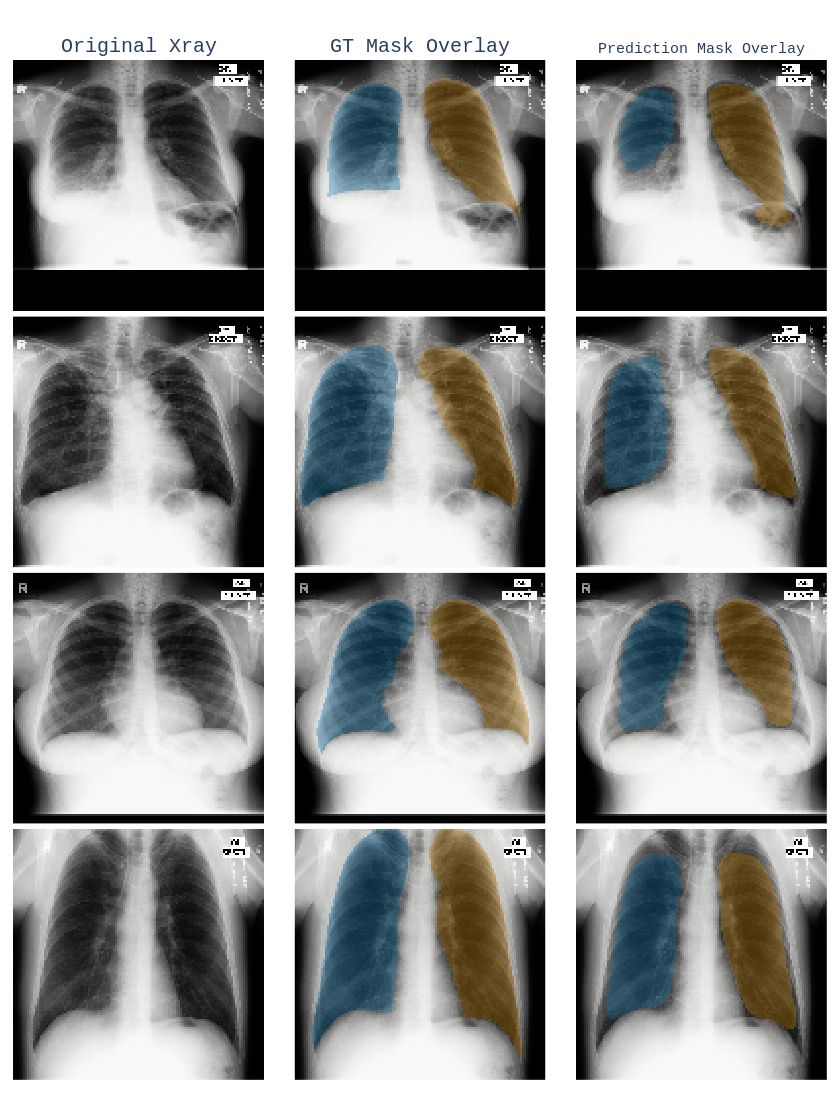

FastEstimator-Train: step: 40; loss: 0.12183587; steps/sec: 1.5;
FastEstimator-Train: step: 56; epoch: 2; epoch_time(sec): 13.02;
FastEstimator-Warn: The following key(s) are being pruned since they are unused outside of the Pipeline. To prevent this, you can declare the key(s) as inputs to Traces or TensorOps: bbox_gt, keypoints
Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 1.22;
Eval Progress: 4/7; steps/sec: 1.86;
Eval Progress: 7/7; steps/sec: 3.69;
FastEstimator-Eval: step: 56; epoch: 2; Dice: 0.9235015; loss: 0.056964148;
FastEstimator-Finish: step: 56; lung_segmentation_lr: 0.0001; total_time(sec): 43.81;


In [17]:
estimator.fit()
